This notebook provides example of **crack propagtion in monolayer graphene sheet**. 

The goal of this exercise is to understand how to **define a geometry containing a pre-existing crack**, 
**apply mechanical loading**, and observe how **the crack grows under tension**.

You will construct a complete input script that performs the following steps:

- Reads an existing graphene atomic structure.

- Applies fixed boundary conditions on two edges.

- Gradually displaces the upper and lower edges in opposite directions.

- Observes crack initiation and propagation during stretching.

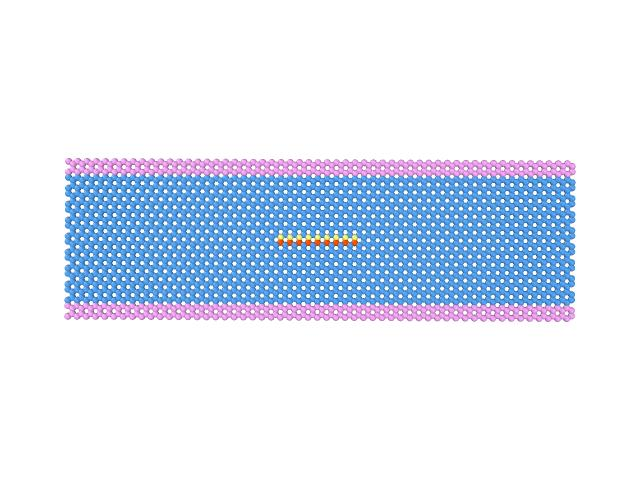

In [3]:
from IPython.display import Image, display
display(Image(filename="monolayer_graphene.jpg"))  

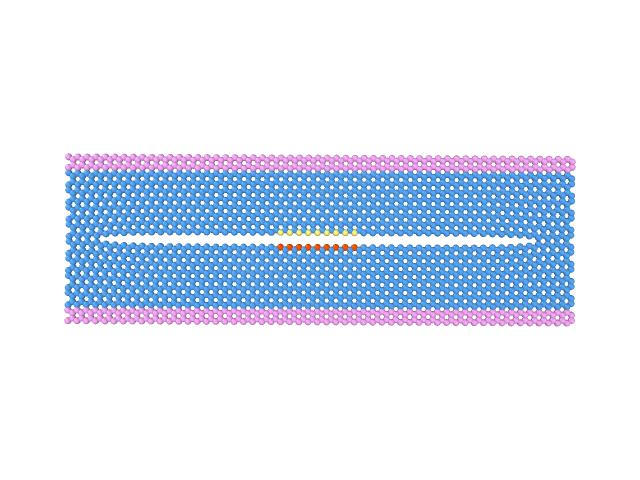

In [4]:
from IPython.display import Image, display
display(Image(filename="graphene_crack.jpg"))  

In [1]:
from lammps import lammps
lmp=lammps()

LAMMPS (29 Aug 2024)


**Simulation Setup**

- Use metal units and 3D simulation dimensions.

- Set mixed boundary conditions in x and y, and periodic in z.

- Use atom_style atomic, and standard neighbor settings (neighbor, neigh_modify).
    
**System Initialization**

- Read atomic positions and box dimensions from a data file -> nx10ny55.

- Assign atomic masses (m=1.0).

In [ ]:
lmp.commands_string("""

units        metal

# GRAPHENE SHEET

dimension       ---
boundary        --- --- ---
---             atomic
neighbor        0.3 bin
neigh_modify    delay 5

read_data       ---  # atom positions and simulation box size will be read from a data file. 

# SET THE MASS OF EACH ATOM (usually insignificant in MS simulations)

mass            1 1.0
mass            2 1.0
mass            3 1.0
mass            4 1.0
mass            5 1.0
""")

**Group Definitions**

- Define boundary regions on both sides of the sheet. 

- Use neigh_modify exclude to remove interactions between two types of atoms to initialize the crack.

**Interatomic Potential**

- Use the rebo pair style with coefficients

- CH.rebo file is given. 

In [ ]:
lmp.commands_string( """

region	    1 block INF 2.9 INF INF INF INF # boundary
group		lower region 1
region		2 block 38.3 INF INF INF INF INF # boundary
group		upper region 2
group		boundary union lower upper
group		mobile subtract all boundary
group       crack_lower type 4
group       crack_upper type 5

set		    group lower type 2
set		    group upper type 3

neigh_modify    --- type --- ---  # generate a crack

# GRAPHENE POTENTIAL

pair_style   rebo  # use REBO potential for graphene simulations
pair_coeff   * * --- C C C C C  # select the pair coefficients file and 5 C's for 5 atoms

""")

**Deformation and Crack Simulation**

- Create custom dump files that outputs Atom ID, type, positions and forces.
  
- Fix the boundary atoms so they do not move vertically.
  
- Choose a time step of 0.003 ps and quickmin minimization style.

- Create a loop to incrementally displace the upper and lower regions.

- Small displacement each iteration.

- Minimize the system at each step, run a few integration steps, then repeat until full tension is achieved.

In [ ]:
lmp.commands_string("""

dump            1 all --- 5000 --- id type xu yu zu fx fy fz
dump_modify     1 sort id

min_style       ---  # choice of optimizer for energy minimization
timestep        ---  # set the timestep

fix             fixingb boundary setforce 0.0 0.0 NULL  # fix the boundary conditions; since its 2D, z-axis is set to NULL

variable        a loop 100  # number of iterations
label           loop  # label name for the loop

displace_atoms  upper move 0.023 0.0 0.0  # displace the atoms in the upper region to generate a crack
displace_atoms  --- move -0.023 0.0 0.0  # displace the atoms in the lower region to generate a crack

minimize        1e-10 1e-10 10000 10000  
run             1  # trigger LAMMPS to run the simulation

next            ---  # what to execute next
""")